# Fababean WOFOST 8.1 SNOMIN

This notebook is based on the example of WOFOST 8.1 SNOMIN made with potato (Fontane) https://github.com/ajwdewit/pcse_notebooks/blob/master/12%20Simulating%20with%20WOFOST%208.1%20SNOMIN.ipynb

# 1. Importing the relevant modules

Required modules to be imported

In [1]:
%matplotlib inline
import sys
from pathlib import Path

from IPython.display import Code
import yaml
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.input import YAMLCropDataProvider

import plots_fababean
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.10.16 (main, Dec  3 2024, 17:27:57) [Clang 16.0.0 (clang-1600.0.26.4)]
PCSE version: 6.0.9


### Setting paths

In [2]:
data_dir = Path.cwd() / "data" 
crop_dir = data_dir / "crop"
sys.path.append(str(data_dir))

## 2. Obtaining input data 
### 2.1 Crop parameters
We read the crop parameters from a local file. The file 'fababean.yaml' was taken from https://github.com/ajwdewit/wofost_crop_parameters on the branch 'wofost81'

In [3]:
crop_dict = YAMLCropDataProvider(fpath=crop_dir)

### 2.2 Soil inputs

In [4]:
PFFieldCapacity = 2.0
PFWiltingPoint = 4.2
SurfaceConductivity = 75.

#layer properties
Thickness = [25., 15., 20., 60]
nlayers = len(Thickness)
CNRatioSOMI = [17., 25., 25., 25.]
CRAIRC = [0.09, 0.09, 0.09, 0.09]
FSOMI = [0.05, 0.02, 0.01, 0.]
RHOD = [1.375, 1.576, 1.633, 1.672]
Soil_pH = [4.8, 4.5, 4.5, 4.7]

#from w81_plotting import plot_SNOMIN_parameters
#fig = plot_SNOMIN_parameters(Thickness, CNRatioSOMI, CRAIRC, FSOMI, RHOD, Soil_pH)

#Hydraulic properties
alpha = [0.02164487, 0.01608317, 0.01608317, 0.01598691]
k_sat = [83.24163508, 22.76175599, 22.76175599, 22.32215442]
labda = [7.20207718, 2.43966226, 2.43966226, 2.8679672]
n = [1.34877009, 1.52441823, 1.52441823, 2.16275113]
theta_r = [0.02, 0.02, 0.02, 0.01]
theta_s = [0.43387803, 0.3870639, 0.3870639, 0.36584689]

#calculate SMfromPF and CONDfromPF for the following pF values
pFs = [-1.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.4, 2.7, 3.0, 3.3, 3.7, 4.0, 4.2, 6.0]

#construct table function SMfromPF and CONDfromPF
from vangenuchten import calculate_water_potential_form_pf, calculate_soil_moisture_content, calculate_log10_hydraulic_conductivity

CONDfromPF_perlayer = []
SMfromPF_perlayer = []

for i in range(nlayers):
    CONDfromPF = []
    SMfromPF = []
    for j, pF in enumerate(pFs):
        r = calculate_soil_moisture_content(pF, alpha[i], n[i], theta_r[i], theta_s[i])
        SMfromPF.extend([pF, r])
        r = calculate_log10_hydraulic_conductivity(pF, alpha[i], labda[i],k_sat[i], n[i])
        CONDfromPF.extend([pF, r])
    CONDfromPF_perlayer.append(CONDfromPF)
    SMfromPF_perlayer.append(SMfromPF)

# from w81_plotting import plot_pF_vs_soilmoisture
# fig = plot_pF_vs_soilmoisture(SMfromPF_perlayer, Thickness, pFs)

# from w81_plotting import plot_pF_vs_conductivity
# fig = plot_pF_vs_conductivity(CONDfromPF_perlayer, Thickness, pFs)

#Build a soil inputs YAML
from vangenuchten import make_string_table

# below we generate the header of the soil input file as YAML input structure
soil_input_yaml = f"""
RDMSOL: {sum(Thickness)}
SoilProfileDescription:
    PFWiltingPoint: {PFWiltingPoint}
    PFFieldCapacity: {PFFieldCapacity}
    SurfaceConductivity: {SurfaceConductivity}
    GroundWater: false
    SoilLayers:
"""

# Here we generate the properties for each soil layer including layer thickness, hydraulic properties, 
# organic matter content, etc.
for i in range(nlayers):
    s = f"""    - Thickness: {Thickness[i]}
      CNRatioSOMI: {CNRatioSOMI[i]}
      CRAIRC: {CRAIRC[i]}
      FSOMI: {FSOMI[i]}
      RHOD: {RHOD[i]}
      Soil_pH: {Soil_pH[i]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[i])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i])}
"""
    soil_input_yaml += s

# A SubSoilType needs to be defined. In this case we make the subsoil equal to the properties
# of the deepest soil layer.
soil_input_yaml += \
f"""    SubSoilType:
      CNRatioSOMI: {CNRatioSOMI[-1]}
      CRAIRC: {CRAIRC[-1]}
      FSOMI: {FSOMI[-1]}
      RHOD: {RHOD[-1]}
      Soil_pH: {Soil_pH[-1]}
      Thickness: {Thickness[-1]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[-1])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i-1])}
"""

# Parse YAML into a valid soil dict first
soil_dict = yaml.safe_load(soil_input_yaml)

# Print the soil input data structure
# Code(soil_input_yaml, language="python")

### 2.3 Specifying site parameters

In [5]:
from pcse.input import WOFOST81SiteDataProvider_SNOMIN
site_dict = WOFOST81SiteDataProvider_SNOMIN(A0SOM=24.0,
                                            CNRatioBio=9.0,
                                            CO2=400.,
                                            FASDIS=0.5,
                                            IFUNRN=0,
                                            KDENIT_REF=0.06,
                                            KNIT_REF=1.0,
                                            KSORP=0.0005,
                                            MRCDIS=0.001,
                                            NH4ConcR=1.0,
                                            NH4I=[5., 0., 0., 0.],
                                            NO3ConcR=4.0,
                                            NO3I=[30., 0., 0., 0.],
                                            NOTINF=1.0,
                                            WFPS_CRIT=0.8,
                                            SMLIM=0.31,
                                            SSI=0.,
                                            SSMAX=0.,
                                            WAV=30.)

### 2.4 Agromanagement files

In [6]:
from pcse.input import YAMLAgroManagementReader
agro_dir = data_dir / "agro"
# I will call them before running the simulation (there are dif. for dif. tests)

### 2.5 Weather data

In [7]:
from pcse.input import ExcelWeatherDataProvider
weather_dir = data_dir / "met"
weather_fname = weather_dir / "example_weather.xlsx"
wdp = ExcelWeatherDataProvider(weather_fname)

## 3. Testing fababean - running the simulation and plotting

#### Tests:

1) NFIX_FR = 0.8 -> error
2) NFIX_FR = 0.8 -> interrupted before error 
3) NFIX_FR = 0.4 -> error
4) NFIX_FR = 0.4 -> interrupted before error
5) NFIX_FR = 0.

#### Plots:

a. TAGP
b. Ndemand, RNUptake, RNfixation, RNUptake+RNfixation
c. Ndemand.cumsum(), RNUptake.cumsum(), RNfixation.cumsum(), RNUptake+RNfixation.cumsum()
d. Root depth
e. NH4 per layer and NO3 per layer

#### + Summary outputs
wofost.get_summary_output()

#### Test 1. NFIX_FR = 0.8 -> error

In [8]:
#### Test 1. 

nfix_fr = 0.8

#change management
agro_fname = agro_dir / "example_agro1.yaml" #max_duration: 400
agro_dict = YAMLAgroManagementReader(agro_fname)

from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)
parameters.set_override("NFIX_FR", nfix_fr, check=False) 

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
output_var_additions = ['RD', 'NH4', 'NO3', 'DOY', "RNuptake",'RNfixation', "N_demand"]
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict, output_vars=output_var_additions)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())

NutrientBalanceError: N flows not balanced on day 2020-05-04
Checksum: 1.357195, Nuptake_T: 0.339299, Nfix_T: 1.357195
NamountLVI: 0.675000, NamountSTI: 0.337500, NamountRTI: 0.675000, NamountSOI: 0.000000
NamountLV: 0.814437, NamountST: 0.405637, NamountRT: 0.806725, NamountSO: 0.000000
NLOSST: 0.000000


#### Test 2. NFIX_FR = 0.8 -> interrupted before error 

In [ ]:
# Nuptake in the doc says... but I see...

AttributeError: 'YAMLAgroManagementReader' object has no attribute 'keys'

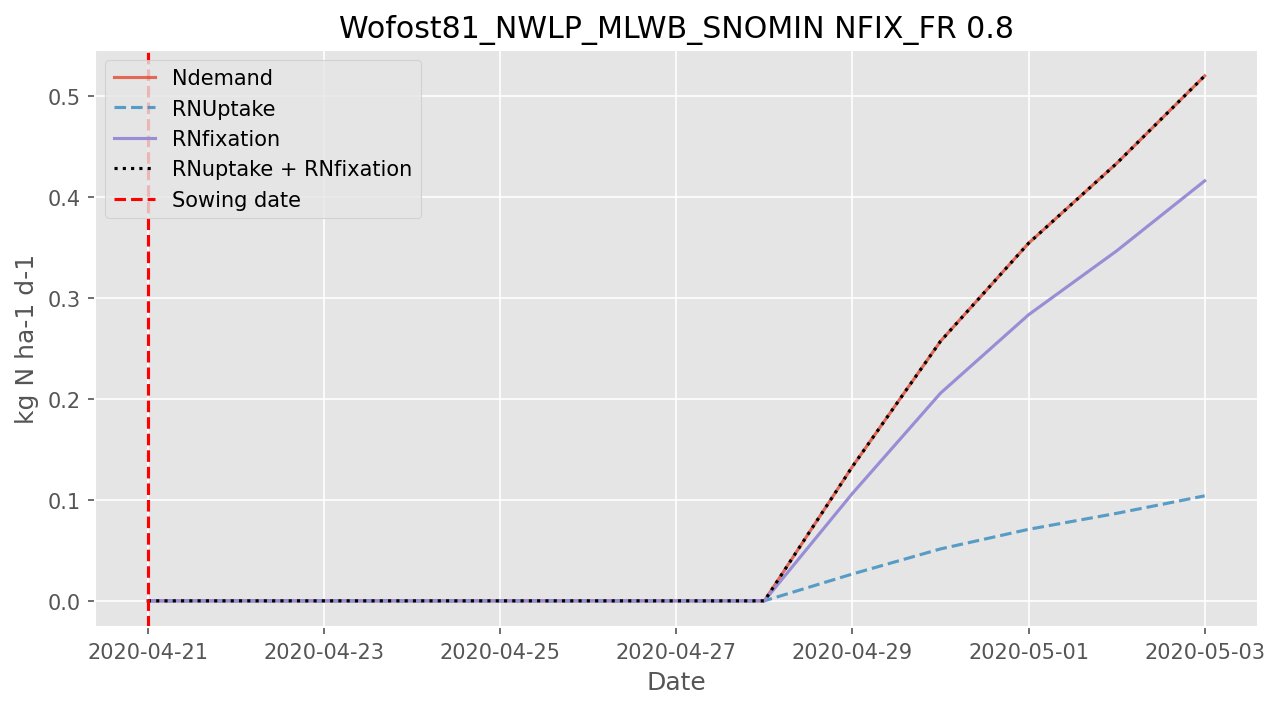

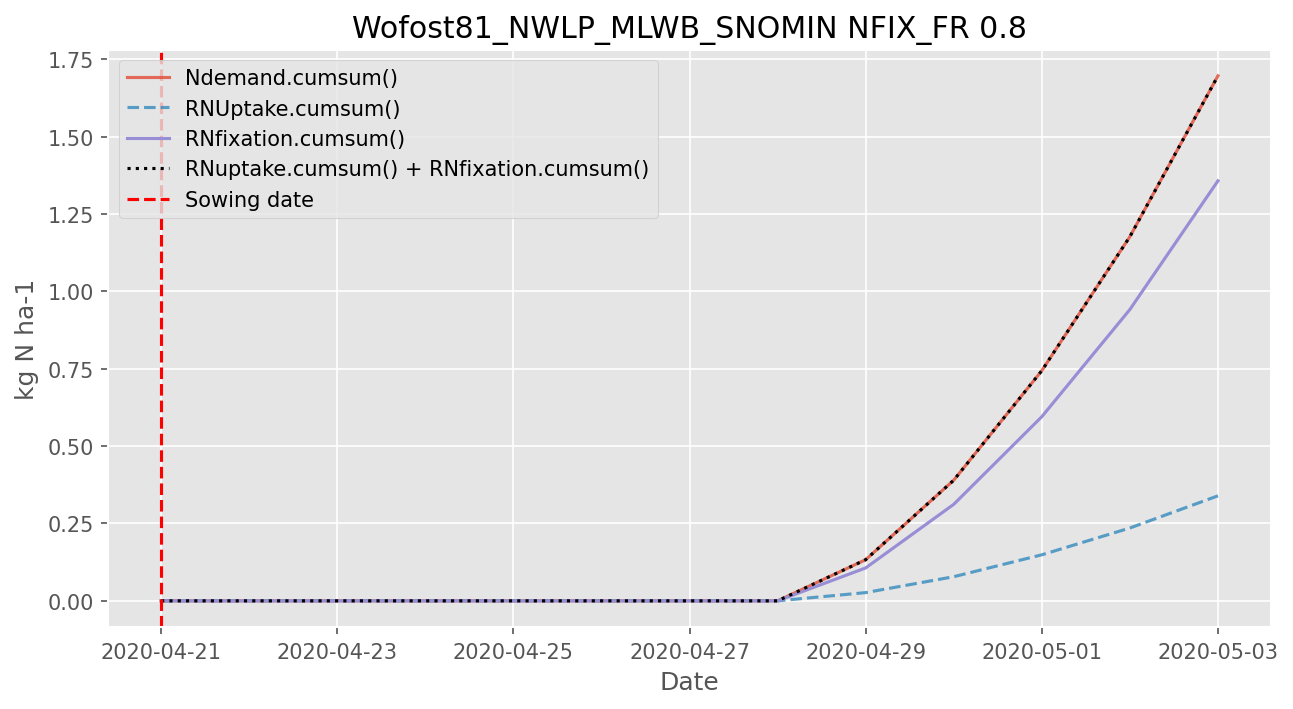

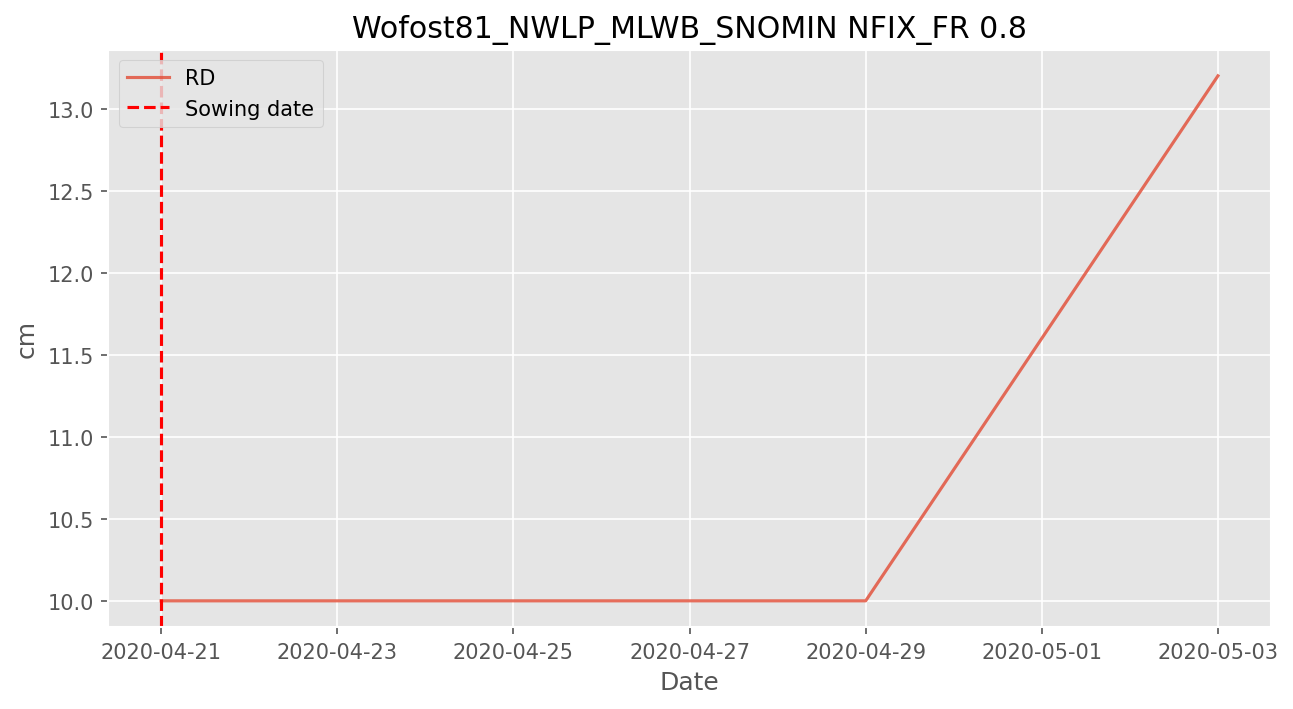

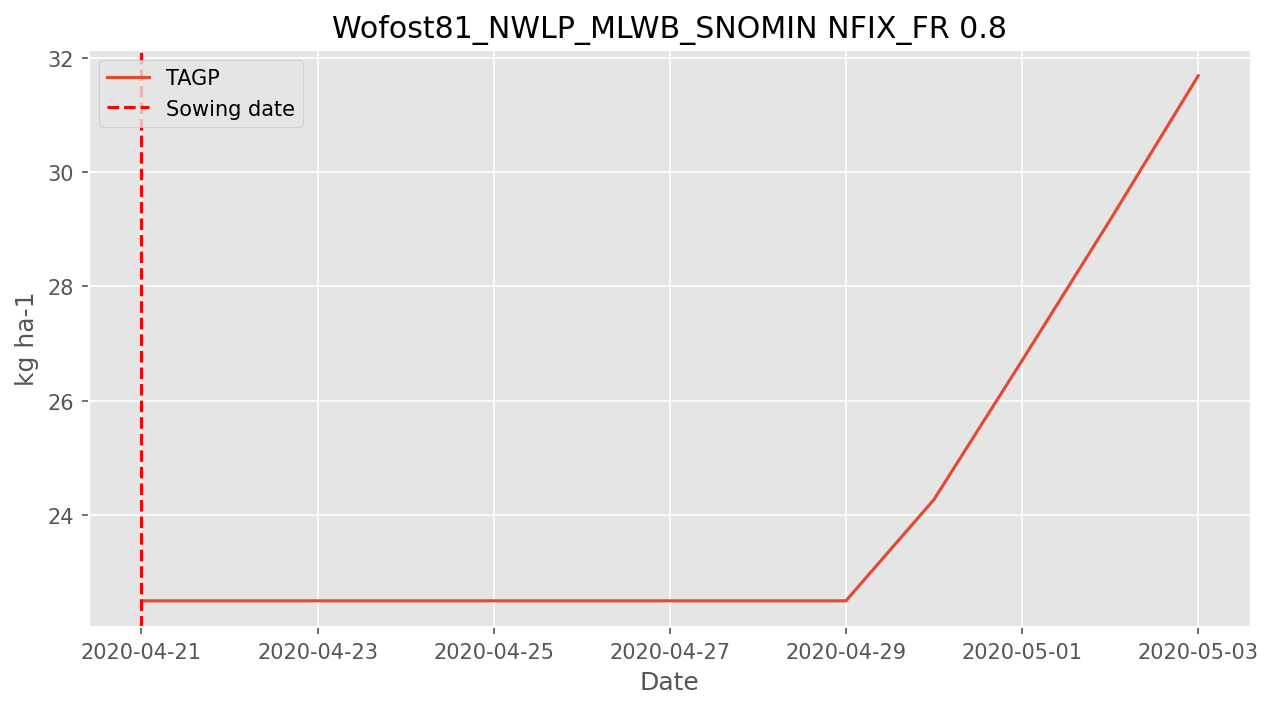

In [11]:
#### Test 2. 
sowingdate = '2020-04-21'
nfix_fr = 0.8

#change management
agro_fname = agro_dir / "example_agro2.yaml" #max_duration: 12
agro_dict = YAMLAgroManagementReader(agro_fname)

from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)
parameters.set_override("NFIX_FR", nfix_fr, check=False) 

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
output_var_additions = ['RD', 'NH4', 'NO3', 'DOY', "RNuptake",'RNfixation', "N_demand"]
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict, output_vars=output_var_additions)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())

plots_fababean.plot_N_rates(df_output, nfix_fr, sowingdate)
plots_fababean.plot_N_rates_cumsum(df_output, nfix_fr, sowingdate)
plots_fababean.plot_root_depth(df_output, nfix_fr, sowingdate)
plots_fababean.plot_TAGB(df_output, nfix_fr, sowingdate)

In [10]:
#### Test 3. 

nfix_fr = 0.4

#change management
agro_fname = agro_dir / "example_agro1.yaml" #max_duration: 400
agro_dict = YAMLAgroManagementReader(agro_fname)

from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)
parameters.set_override("NFIX_FR", nfix_fr, check=False) 

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
output_var_additions = ['RD', 'NH4', 'NO3', 'DOY', "RNuptake",'RNfixation', "N_demand"]
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict, output_vars=output_var_additions)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())

NutrientBalanceError: N flows not balanced on day 2020-05-08
Checksum: 1.069261, Nuptake_T: 1.603891, Nfix_T: 1.069261
NamountLVI: 0.675000, NamountSTI: 0.337500, NamountRTI: 0.675000, NamountSOI: 0.000000
NamountLV: 1.360578, NamountST: 0.661155, NamountRT: 1.269658, NamountSO: 0.000000
NLOSST: 0.000000


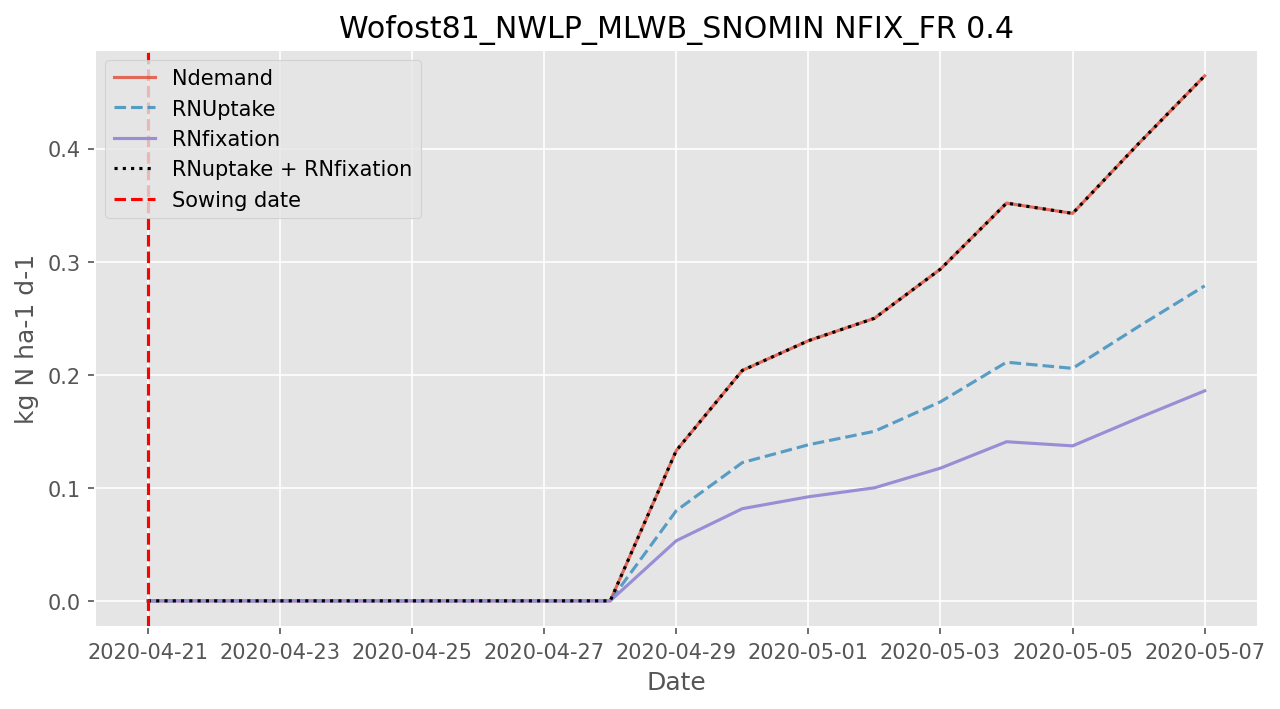

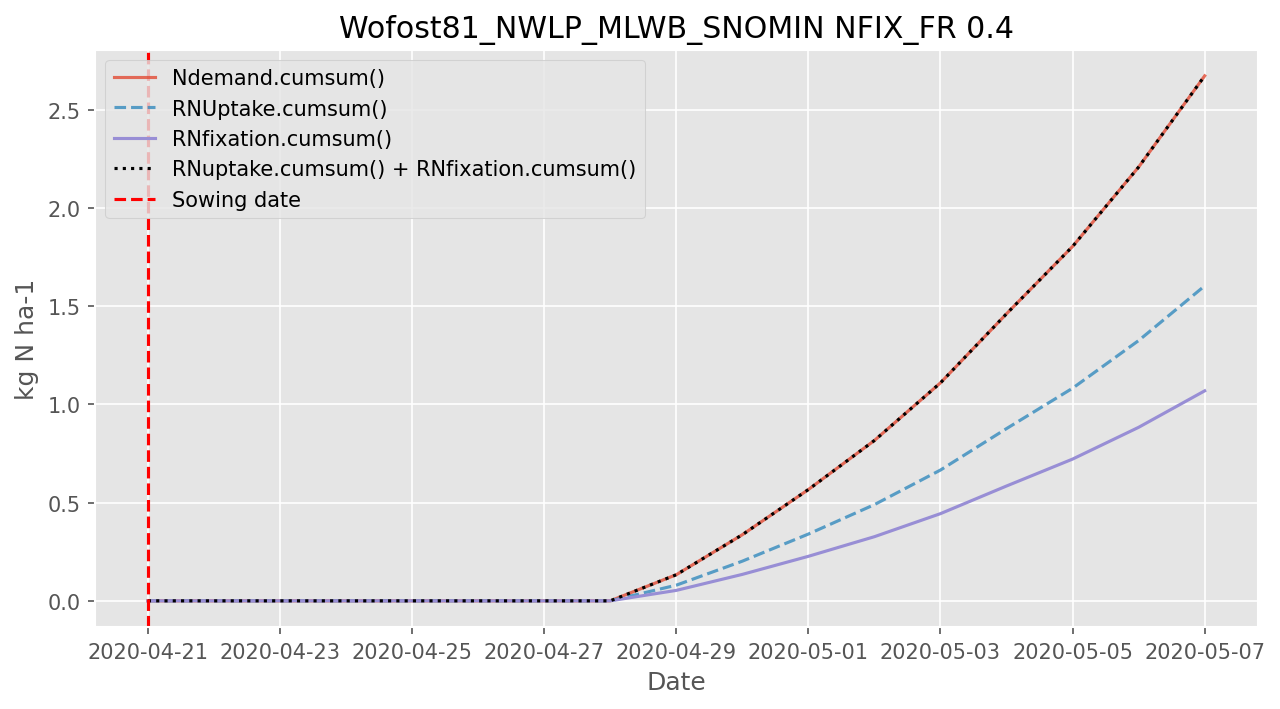

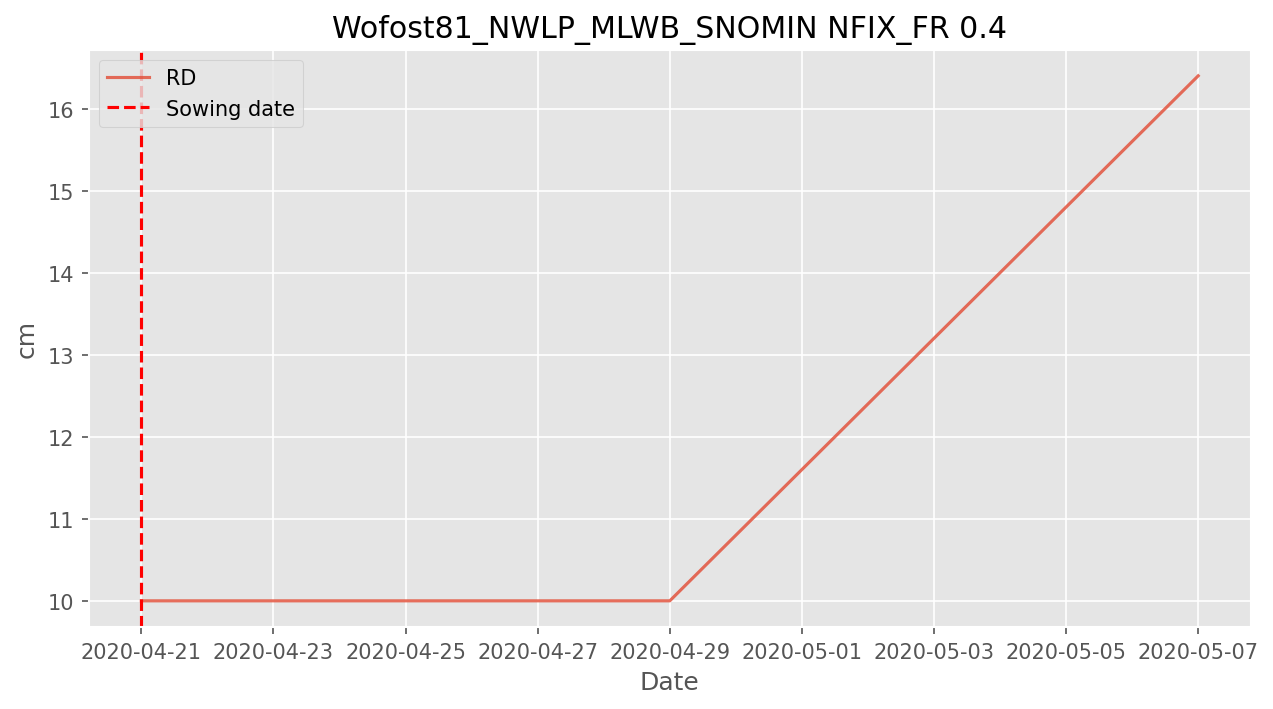

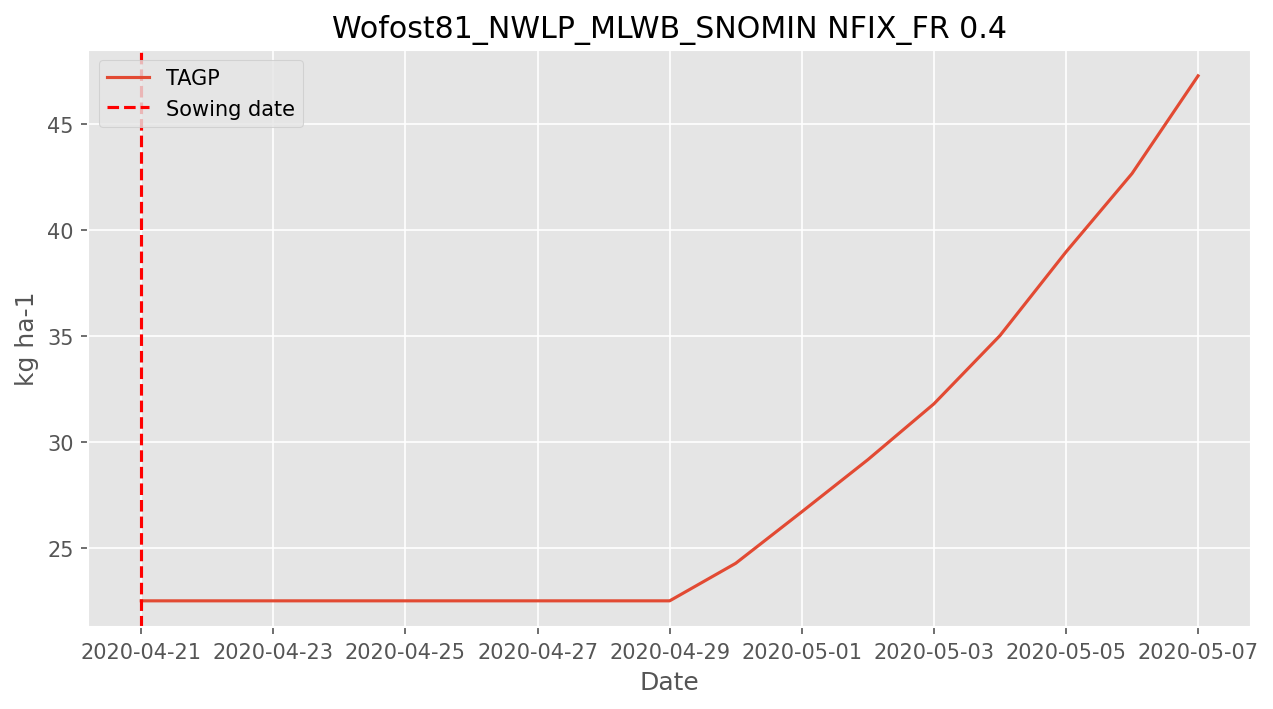

In [12]:
#### Test 4. 

nfix_fr = 0.4

#change management
agro_fname = agro_dir / "example_agro3.yaml" #max_duration: 16
agro_dict = YAMLAgroManagementReader(agro_fname)

from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)
parameters.set_override("NFIX_FR", nfix_fr, check=False) 

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
output_var_additions = ['RD', 'NH4', 'NO3', 'DOY', "RNuptake",'RNfixation', "N_demand"]
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict, output_vars=output_var_additions)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())


plots_fababean.plot_N_rates(df_output, nfix_fr, sowingdate)
plots_fababean.plot_N_rates_cumsum(df_output, nfix_fr, sowingdate)
plots_fababean.plot_root_depth(df_output, nfix_fr, sowingdate)
plots_fababean.plot_TAGB(df_output, nfix_fr, sowingdate)

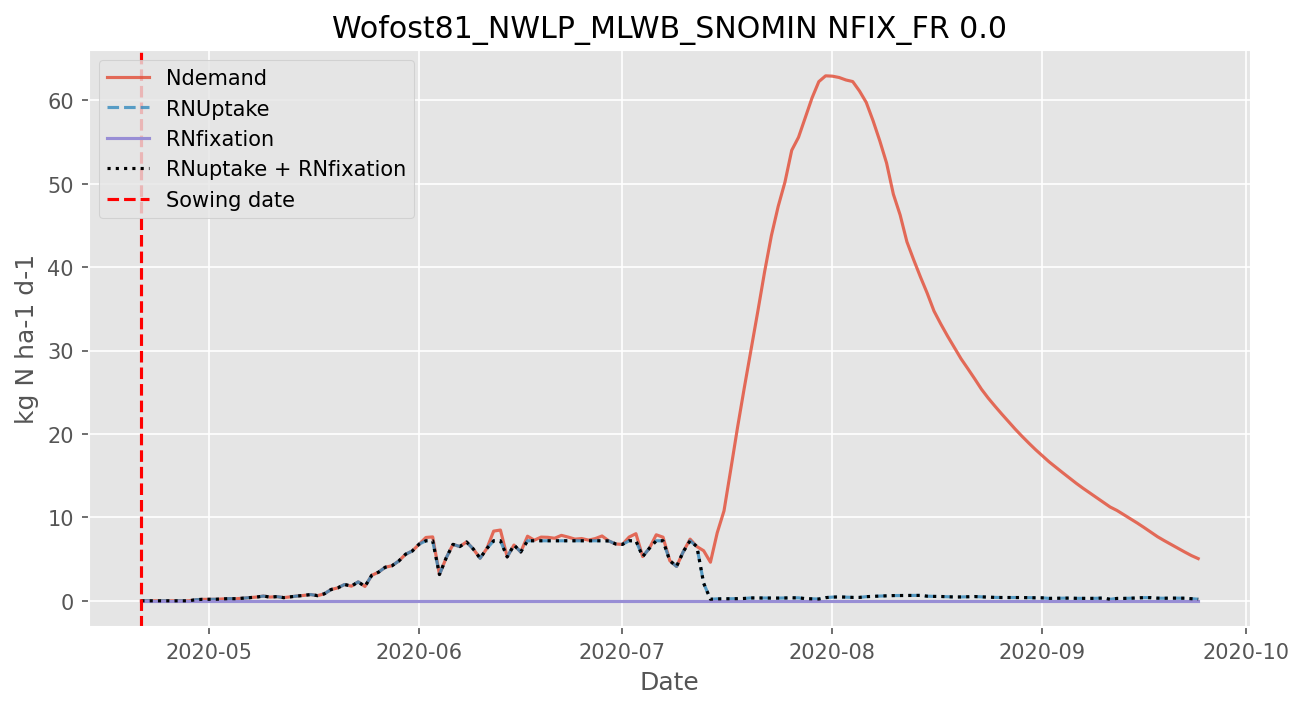

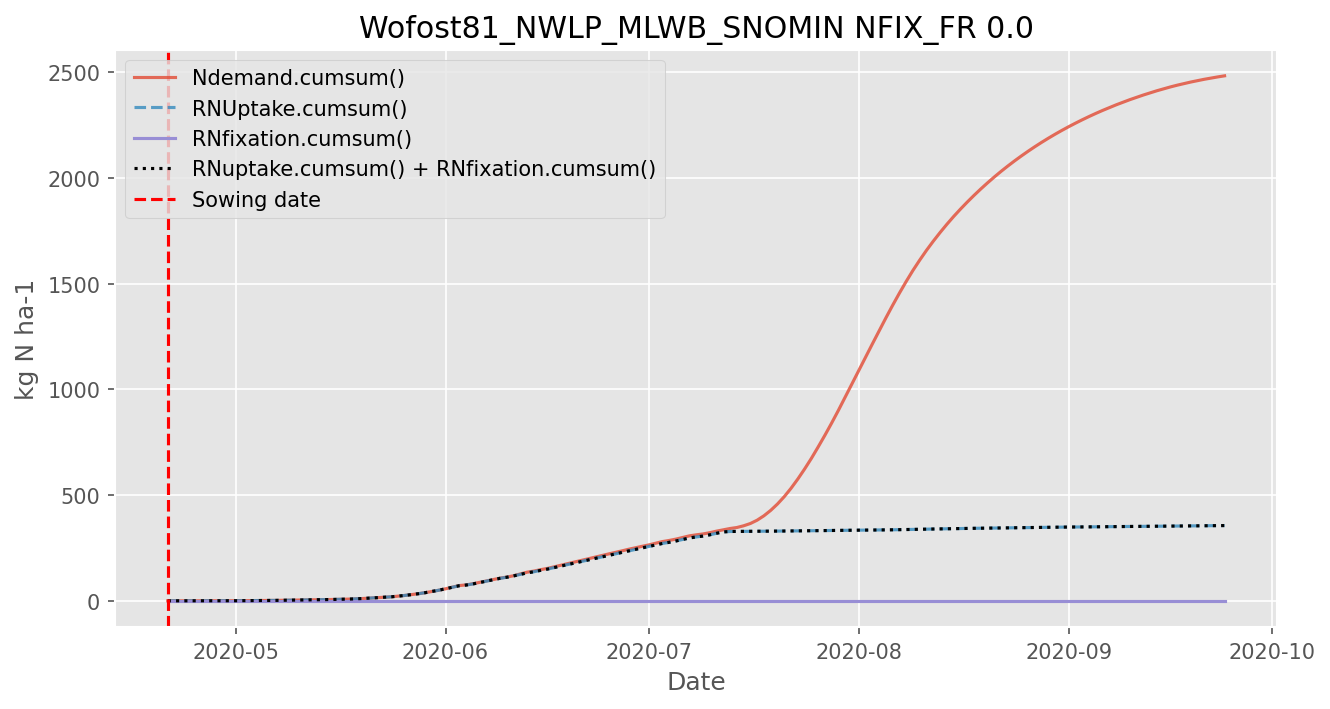

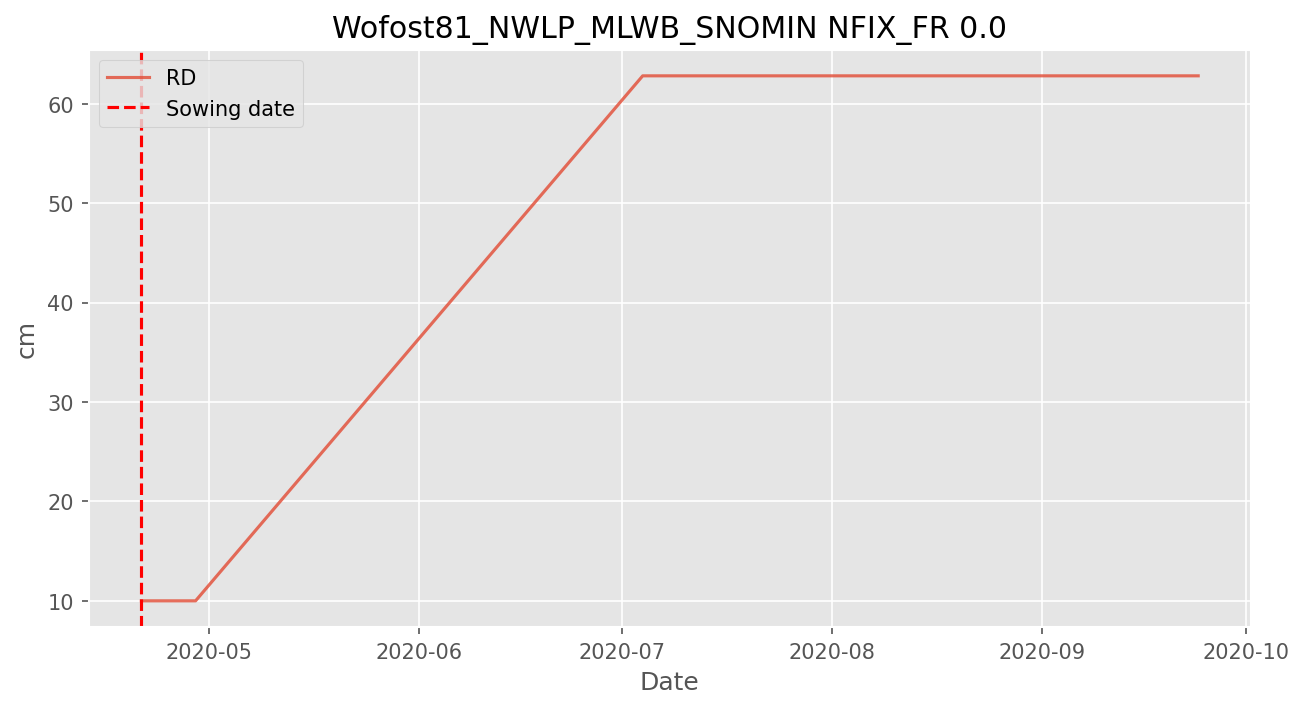

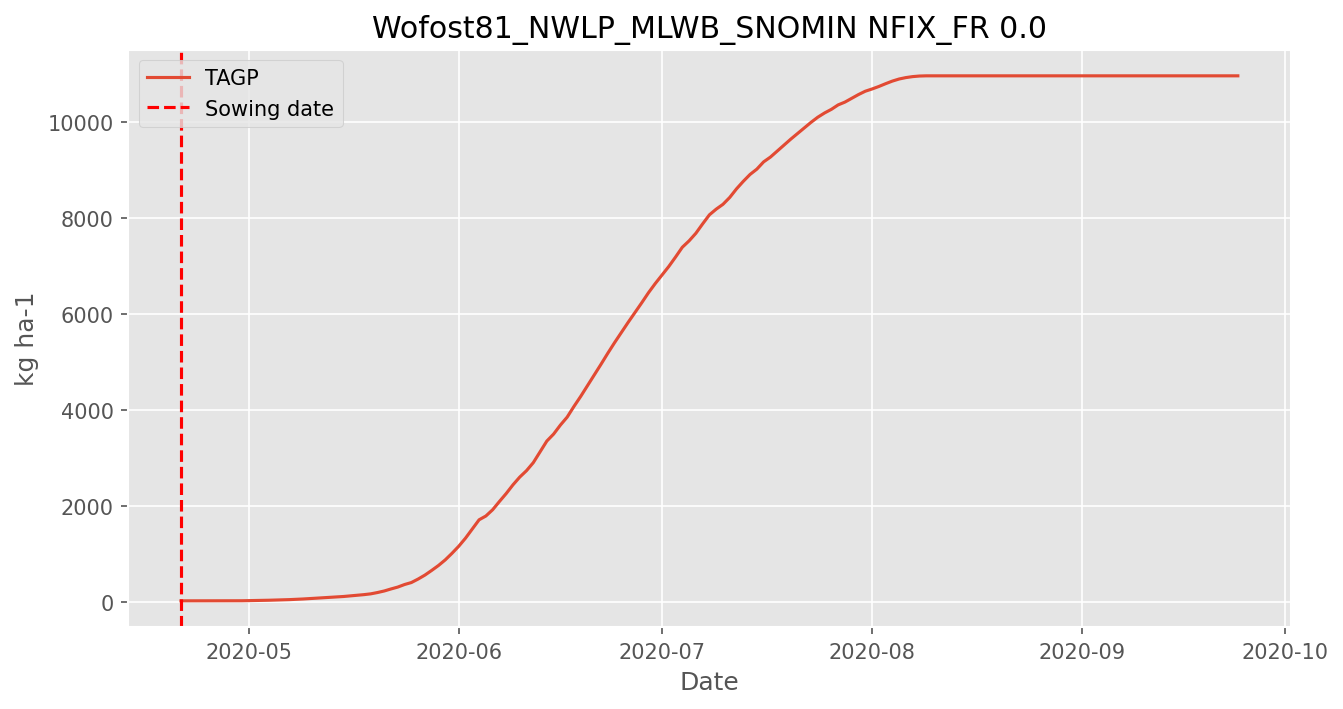

In [13]:
#### Test 5. 

nfix_fr = 0.

#change management
agro_fname = agro_dir / "example_agro1.yaml" #max_duration: 400
agro_dict = YAMLAgroManagementReader(agro_fname)

from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)
parameters.set_override("NFIX_FR", nfix_fr, check=False) 

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
output_var_additions = ['RD', 'NH4', 'NO3', 'DOY', "RNuptake",'RNfixation', "N_demand"]
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict, output_vars=output_var_additions)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())


plots_fababean.plot_N_rates(df_output, nfix_fr, sowingdate)
plots_fababean.plot_N_rates_cumsum(df_output, nfix_fr, sowingdate)
plots_fababean.plot_root_depth(df_output, nfix_fr, sowingdate)
plots_fababean.plot_TAGB(df_output, nfix_fr, sowingdate)